Skipping baseline_single_shot r3 in GPU Line Graph: crashed at 4.2s (expected >500.0s)
Skipping think_step_by_step r2 in GPU Line Graph: crashed at 275.5s (expected >900.0s)
Skipping think_step_by_step r3 in GPU Line Graph: crashed at 427.0s (expected >900.0s)


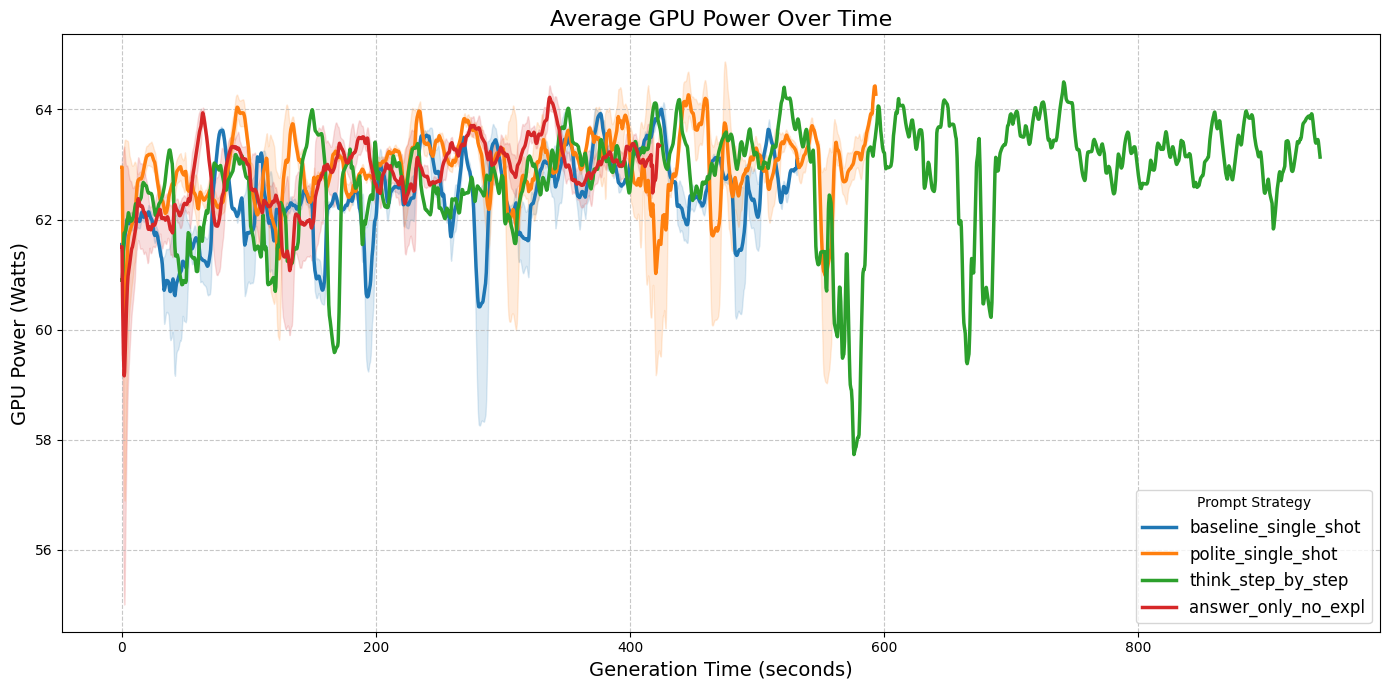

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings('ignore', category=RuntimeWarning)

base_path = "../outputs/final_results/deepseek-ai_deepseek-coder-1.3b-instruct"
prompt_types = ['baseline_single_shot', 'polite_single_shot', 'think_step_by_step', 'answer_only_no_expl']
runs = ['r1', 'r2', 'r3'] 

START_CUTOFF_SECONDS = 25.0
END_TRIM_SECONDS = 10.0

expected_minimums = {
    'answer_only_no_expl': 400.0,
    'baseline_single_shot': 500.0,
    'polite_single_shot': 600.0,
    'think_step_by_step': 900.0
}

plt.figure(figsize=(14, 7))

for pt in prompt_types:
    df_list = []
    
    for r in runs:
        file_path = f"{base_path}/{pt}/humaneval_custom/{r}/energy.csv"
        if not os.path.exists(file_path): 
            continue
        
        df = pd.read_csv(file_path)
        if df.empty:
            continue
            
        df['Relative_Time_s'] = (df['Time'] - df['Time'].iloc[0]) / 1000.0
        run_end_time = df['Relative_Time_s'].max()
        
        min_required = expected_minimums.get(pt, 0.0)
        if run_end_time < min_required:
            print(f"Skipping {pt} {r} in GPU Line Graph: crashed at {run_end_time:.1f}s (expected >{min_required}s)")
            continue
        
        df_zoomed = df[(df['Relative_Time_s'] >= START_CUTOFF_SECONDS) & 
                       (df['Relative_Time_s'] <= (run_end_time - END_TRIM_SECONDS))].copy()
                       
        if df_zoomed.empty: 
            continue
            
        df_zoomed['Aligned_Time_s'] = df_zoomed['Relative_Time_s'] - START_CUTOFF_SECONDS
        
        df_zoomed['GPU_Power_W'] = df_zoomed['GPU0_POWER (mWatts)'] / 1000.0
        df_zoomed['GPU_Power_Smoothed'] = df_zoomed['GPU_Power_W'].rolling(window=50, min_periods=1).mean()
        
        df_zoomed = df_zoomed.drop_duplicates(subset=['Aligned_Time_s'])
        df_list.append(df_zoomed)
        
    if not df_list: 
        continue
        
    max_time = max([d['Aligned_Time_s'].max() for d in df_list])
    
    common_time = np.arange(0, max_time, 0.1)
    
    interpolated_powers = []
    for d in df_list:
        interp_pwr = np.interp(common_time, d['Aligned_Time_s'], d['GPU_Power_Smoothed'], right=np.nan)
        interpolated_powers.append(interp_pwr)
        
    power_matrix = np.array(interpolated_powers)
    mean_power = np.nanmean(power_matrix, axis=0)
    std_power = np.nanstd(power_matrix, axis=0)
    
    line, = plt.plot(common_time, mean_power, label=pt, linewidth=2.5)
    plt.fill_between(common_time, mean_power - std_power, mean_power + std_power, 
                     color=line.get_color(), alpha=0.15)

plt.title('Average GPU Power Over Time', fontsize=16)
plt.xlabel('Generation Time (seconds)', fontsize=14)
plt.ylabel('GPU Power (Watts)', fontsize=14)
plt.legend(title='Prompt Strategy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Skipping baseline_single_shot r3 in Line Graph: crashed at 4.2s
Skipping think_step_by_step r2 in Line Graph: crashed at 275.5s
Skipping think_step_by_step r3 in Line Graph: crashed at 427.0s


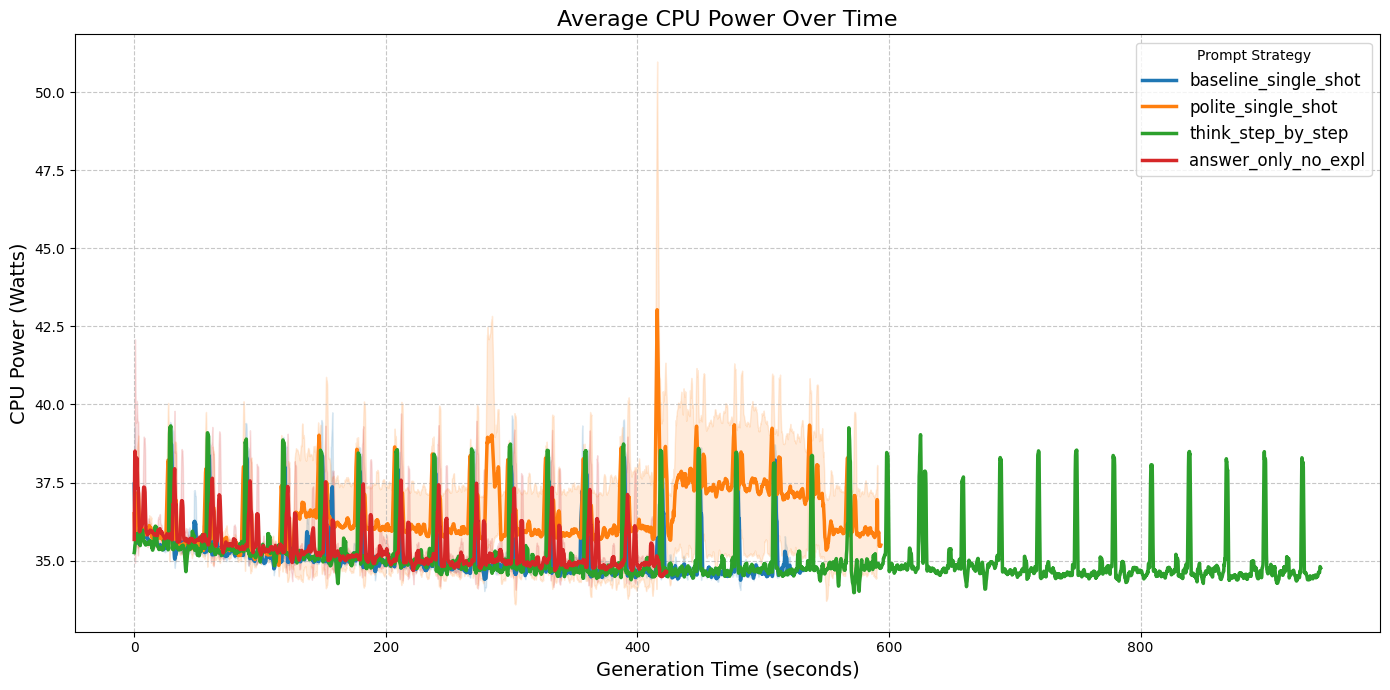

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings('ignore', category=RuntimeWarning)

base_path = "../outputs/final_results/deepseek-ai_deepseek-coder-1.3b-instruct"
prompt_types = ['baseline_single_shot', 'polite_single_shot', 'think_step_by_step', 'answer_only_no_expl']
runs = ['r1', 'r2', 'r3']

START_CUTOFF_SECONDS = 25.0
END_TRIM_SECONDS = 10.0

expected_minimums = {
    'answer_only_no_expl': 400.0,
    'baseline_single_shot': 500.0,
    'polite_single_shot': 600.0,
    'think_step_by_step': 900.0
}

plt.figure(figsize=(14, 7))

for pt in prompt_types:
    df_list = []
    
    for r in runs:
        file_path = f"{base_path}/{pt}/humaneval_custom/{r}/energy.csv"
        if not os.path.exists(file_path): 
            continue
        
        df = pd.read_csv(file_path)
        if df.empty:
            continue
            
        df['Relative_Time_s'] = (df['Time'] - df['Time'].iloc[0]) / 1000.0
        
        # SAFETY FILTER
        total_duration = df['Relative_Time_s'].max()
        min_required = expected_minimums.get(pt, 0.0)
        if total_duration < min_required:
            print(f"Skipping {pt} {r} in Line Graph: crashed at {total_duration:.1f}s")
            continue
        
        df['CPU_Energy_Diff'] = df['CPU_ENERGY (J)'].diff()
        df['Time_Diff_s'] = df['Time'].diff() / 1000.0
        df['CPU_Power_W'] = df['CPU_Energy_Diff'] / df['Time_Diff_s']
        
        run_end_time = df['Relative_Time_s'].max()
        
        df_zoomed = df[(df['Relative_Time_s'] >= START_CUTOFF_SECONDS) & 
                       (df['Relative_Time_s'] <= (run_end_time - END_TRIM_SECONDS))].copy()
                       
        if df_zoomed.empty: 
            continue
            
        df_zoomed['Aligned_Time_s'] = df_zoomed['Relative_Time_s'] - START_CUTOFF_SECONDS
        
        df_zoomed['CPU_Power_Smoothed'] = df_zoomed['CPU_Power_W'].rolling(window=10, min_periods=1).mean()
        
        df_zoomed = df_zoomed.drop_duplicates(subset=['Aligned_Time_s'])
        df_list.append(df_zoomed)
        
    if not df_list: 
        continue
        
    max_time = max([d['Aligned_Time_s'].max() for d in df_list])
    common_time = np.arange(0, max_time, 0.1)
    
    interpolated_powers = []
    for d in df_list:
        interp_pwr = np.interp(common_time, d['Aligned_Time_s'], d['CPU_Power_Smoothed'], right=np.nan)
        interpolated_powers.append(interp_pwr)
        
    power_matrix = np.array(interpolated_powers)
    mean_power = np.nanmean(power_matrix, axis=0)
    std_power = np.nanstd(power_matrix, axis=0)
    
    line, = plt.plot(common_time, mean_power, label=pt, linewidth=2.5)
    plt.fill_between(common_time, mean_power - std_power, mean_power + std_power, 
                     color=line.get_color(), alpha=0.15)

plt.title('Average CPU Power Over Time', fontsize=16)
plt.xlabel('Generation Time (seconds)', fontsize=14)
plt.ylabel('CPU Power (Watts)', fontsize=14)
plt.legend(title='Prompt Strategy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Skipping baseline_single_shot r3 in Bar Chart: crashed at 4.2s
Skipping think_step_by_step r2 in Bar Chart: crashed at 275.5s
Skipping think_step_by_step r3 in Bar Chart: crashed at 427.0s


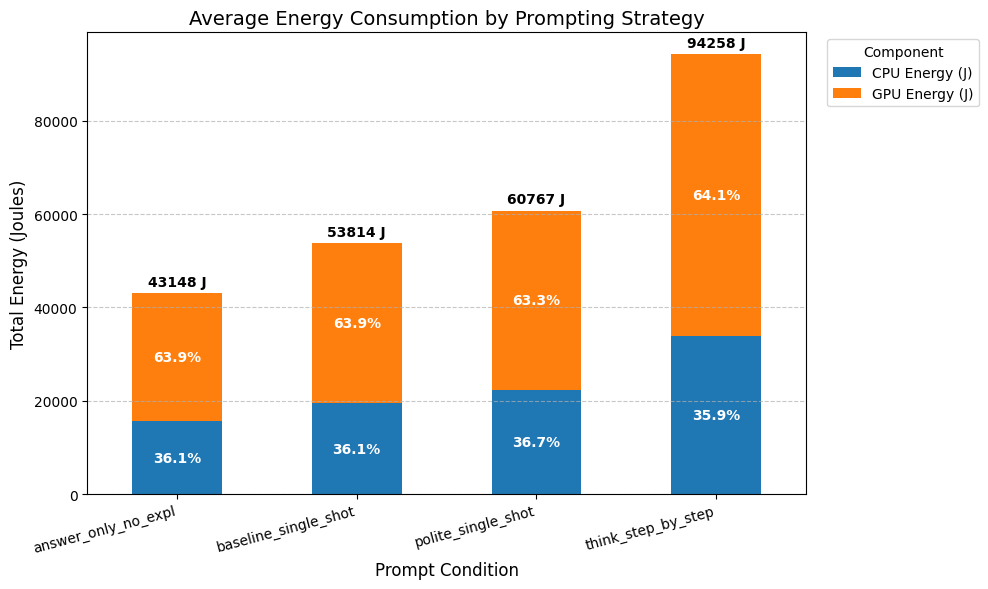

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

files = glob.glob("../outputs/final_results/deepseek-ai_deepseek-coder-1.3b-instruct/*/humaneval_custom/*/energy.csv")

START_CUTOFF_SECONDS = 15.0  

expected_minimums = {
    'answer_only_no_expl': 400.0,
    'baseline_single_shot': 500.0,
    'polite_single_shot': 600.0,
    'think_step_by_step': 900.0
}

results = []
for f in files:
    f_norm = f.replace('\\', '/')
    parts = f_norm.split('/')
    condition = parts[-4] 
    run_id = parts[-2]    
    
    df = pd.read_csv(f)
    if df.empty:
        continue
        
    df['Relative_Time_s'] = (df['Time'] - df['Time'].iloc[0]) / 1000.0
    
    total_duration = df['Relative_Time_s'].max()
    min_required = expected_minimums.get(condition, 0.0)
    if total_duration < min_required:
        print(f"Skipping {condition} {run_id} in Bar Chart: crashed at {total_duration:.1f}s")
        continue
    
    df_filtered = df[df['Relative_Time_s'] >= START_CUTOFF_SECONDS].copy()
    if df_filtered.empty:
        continue
    
    total_cpu_energy = df_filtered['CPU_ENERGY (J)'].max() - df_filtered['CPU_ENERGY (J)'].min()
    
    df_filtered['Time_Diff_s'] = df_filtered['Time'].diff() / 1000.0
    df_filtered['GPU_Power_W'] = df_filtered['GPU0_POWER (mWatts)'] / 1000.0
    total_gpu_energy = (df_filtered['GPU_Power_W'] * df_filtered['Time_Diff_s'].fillna(0)).sum()
    
    results.append({
        'Condition': condition,
        'Run': run_id,
        'CPU Energy (J)': total_cpu_energy,
        'GPU Energy (J)': total_gpu_energy
    })

results_df = pd.DataFrame(results)

agg_df = results_df.groupby('Condition').mean(numeric_only=True).reset_index()
agg_df = agg_df.sort_values(by='GPU Energy (J)') 

ax = agg_df.set_index('Condition')[['CPU Energy (J)', 'GPU Energy (J)']].plot(
    kind='bar', stacked=True, figsize=(10, 6), color=['#1f77b4', '#ff7f0e']
)

plt.title('Average Energy Consumption by Prompting Strategy', fontsize=14)
plt.ylabel('Total Energy (Joules)', fontsize=12)
plt.xlabel('Prompt Condition', fontsize=12)
plt.xticks(rotation=15, ha='right')

plt.legend(title='Component', loc='upper left', bbox_to_anchor=(1.02, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)

totals = agg_df['CPU Energy (J)'] + agg_df['GPU Energy (J)']

cpu_percentages = [f"{(val/total)*100:.1f}%" for val, total in zip(agg_df['CPU Energy (J)'], totals)]
ax.bar_label(ax.containers[0], labels=cpu_percentages, label_type='center', color='white', weight='bold')

gpu_percentages = [f"{(val/total)*100:.1f}%" for val, total in zip(agg_df['GPU Energy (J)'], totals)]
ax.bar_label(ax.containers[1], labels=gpu_percentages, label_type='center', color='white', weight='bold')

ax.bar_label(ax.containers[1], fmt='%d J', label_type='edge', padding=3, weight='bold', color='black')

plt.tight_layout()
plt.show()

Skipping baseline_single_shot r3: crashed at 4.2s (expected >500.0s)
Skipping think_step_by_step r2: crashed at 275.5s (expected >900.0s)
Skipping think_step_by_step r3: crashed at 427.0s (expected >900.0s)


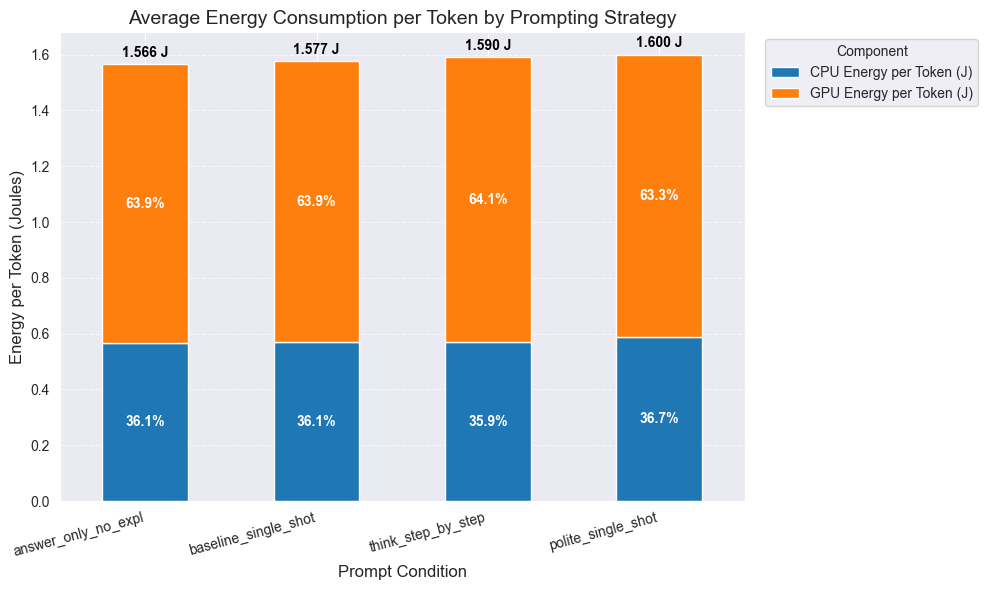

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import glob
from transformers import AutoTokenizer

model_name = "deepseek-ai/deepseek-coder-1.3b-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)

files = glob.glob("../outputs/final_results/deepseek-ai_deepseek-coder-1.3b-instruct/*/humaneval_custom/*/energy.csv")

START_CUTOFF_SECONDS = 15.0  

results = []
for f in files:
    f_norm = f.replace('\\', '/')
    parts = f_norm.split('/')
    condition = parts[-4] 
    run_id = parts[-2]    
        
    results_file = f.replace('energy.csv', 'detailed_results.json')
    if not os.path.exists(results_file):
        continue
        
    df = pd.read_csv(f)
    df['Relative_Time_s'] = (df['Time'] - df['Time'].iloc[0]) / 1000.0
    
    expected_minimums = {
        'answer_only_no_expl': 400.0,
        'baseline_single_shot': 500.0,
        'polite_single_shot': 600.0,
        'think_step_by_step': 900.0
    }
    
    total_duration = df['Relative_Time_s'].max()
    min_required = expected_minimums.get(condition, 0.0)
    
    if total_duration < min_required:
        print(f"Skipping {condition} {run_id}: crashed at {total_duration:.1f}s (expected >{min_required}s)")
        continue
        
    df_filtered = df[df['Relative_Time_s'] >= START_CUTOFF_SECONDS].copy()
    if df_filtered.empty:
        continue
        
    with open(results_file, 'r', encoding='utf-8') as rf:
        detailed_results = json.load(rf)
        
    total_tokens = 0
    for task in detailed_results:
        response_text = task.get('raw_response', '')
        if response_text:
            tokens = tokenizer.encode(response_text, add_special_tokens=False)
            total_tokens += len(tokens)
    
    if total_tokens == 0:
        continue
    
    total_cpu_energy = df_filtered['CPU_ENERGY (J)'].max() - df_filtered['CPU_ENERGY (J)'].min()
    
    df_filtered['Time_Diff_s'] = df_filtered['Time'].diff() / 1000.0
    df_filtered['GPU_Power_W'] = df_filtered['GPU0_POWER (mWatts)'] / 1000.0
    total_gpu_energy = (df_filtered['GPU_Power_W'] * df_filtered['Time_Diff_s'].fillna(0)).sum()
    
    results.append({
        'Condition': condition,
        'Run': run_id,
        'CPU Energy per Token (J)': total_cpu_energy / total_tokens,
        'GPU Energy per Token (J)': total_gpu_energy / total_tokens
    })

results_df = pd.DataFrame(results)

agg_df = results_df.groupby('Condition').mean(numeric_only=True).reset_index()

agg_df['Total Energy per Token (J)'] = agg_df['CPU Energy per Token (J)'] + agg_df['GPU Energy per Token (J)']
agg_df = agg_df.sort_values(by='Total Energy per Token (J)') 

ax = agg_df.set_index('Condition')[['CPU Energy per Token (J)', 'GPU Energy per Token (J)']].plot(
    kind='bar', stacked=True, figsize=(10, 6), color=['#1f77b4', '#ff7f0e']
)

plt.title('Average Energy Consumption per Token by Prompting Strategy', fontsize=14)
plt.ylabel('Energy per Token (Joules)', fontsize=12)
plt.xlabel('Prompt Condition', fontsize=12)
plt.xticks(rotation=15, ha='right')

plt.legend(title='Component', loc='upper left', bbox_to_anchor=(1.02, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)

totals = agg_df['Total Energy per Token (J)']

cpu_percentages = [f"{(val/total)*100:.1f}%" for val, total in zip(agg_df['CPU Energy per Token (J)'], totals)]
ax.bar_label(ax.containers[0], labels=cpu_percentages, label_type='center', color='white', weight='bold')

gpu_percentages = [f"{(val/total)*100:.1f}%" for val, total in zip(agg_df['GPU Energy per Token (J)'], totals)]
ax.bar_label(ax.containers[1], labels=gpu_percentages, label_type='center', color='white', weight='bold')

total_labels = [f"{val:.3f} J" for val in totals]
ax.bar_label(ax.containers[1], labels=total_labels, label_type='edge', padding=3, weight='bold', color='black')

plt.tight_layout()
plt.show()

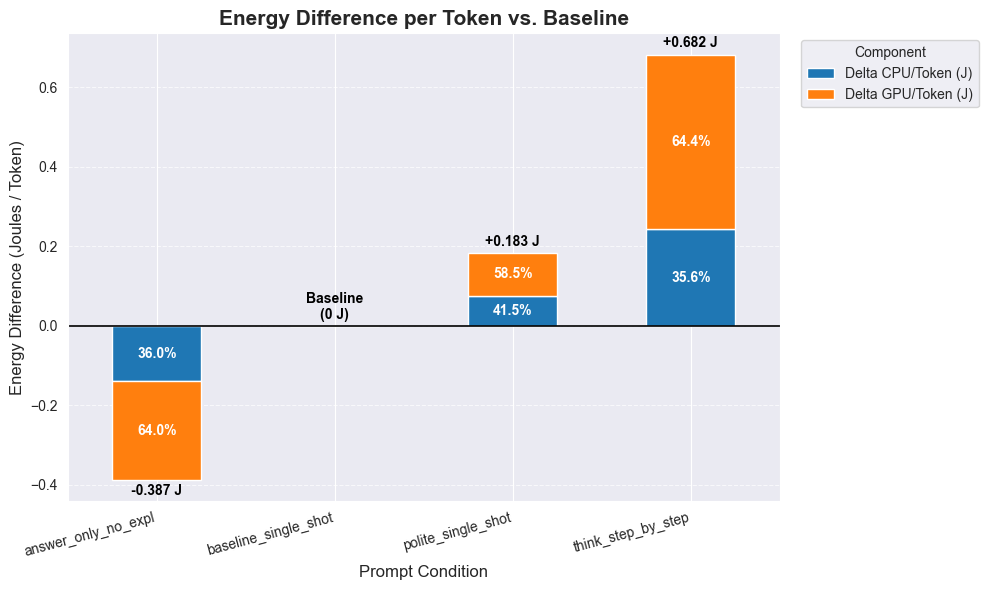

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import glob
from transformers import AutoTokenizer

# 1. Initialize the correct tokenizer
model_name = "deepseek-ai/deepseek-coder-1.3b-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Fetch all energy files
files = glob.glob("../outputs/final_results/deepseek-ai_deepseek-coder-1.3b-instruct/*/humaneval_custom/*/energy.csv")

START_CUTOFF_SECONDS = 15.0  

expected_minimums = {
    'answer_only_no_expl': 400.0,
    'baseline_single_shot': 500.0,
    'polite_single_shot': 600.0,
    'think_step_by_step': 900.0
}

results = []
for f in files:
    # Safely split paths regardless of OS
    f_norm = f.replace('\\', '/')
    parts = f_norm.split('/')
    condition = parts[-4] 
    run_id = parts[-2]    
        
    results_file = f.replace('energy.csv', 'detailed_results.json')
    if not os.path.exists(results_file):
        continue
        
    # Process Energy Data first to check for crashes
    df = pd.read_csv(f)
    if df.empty:
        continue
        
    df['Relative_Time_s'] = (df['Time'] - df['Time'].iloc[0]) / 1000.0
    
    # SAFETY FILTER
    total_duration = df['Relative_Time_s'].max()
    min_required = expected_minimums.get(condition, 0.0)
    if total_duration < min_required:
        continue
        
    df_filtered = df[df['Relative_Time_s'] >= START_CUTOFF_SECONDS].copy()
    if df_filtered.empty:
        continue
        
    # Calculate Exact Total Generated Tokens using the tokenizer
    with open(results_file, 'r', encoding='utf-8') as rf:
        detailed_results = json.load(rf)
        
    total_tokens = 0
    for task in detailed_results:
        response_text = task.get('raw_response', '')
        if response_text:
            # We set add_special_tokens=False because we strictly want the output length
            tokens = tokenizer.encode(response_text, add_special_tokens=False)
            total_tokens += len(tokens)
    
    if total_tokens == 0:
        continue
    
    # Calculate Energies
    total_cpu_energy = df_filtered['CPU_ENERGY (J)'].max() - df_filtered['CPU_ENERGY (J)'].min()
    
    df_filtered['Time_Diff_s'] = df_filtered['Time'].diff() / 1000.0
    df_filtered['GPU_Power_W'] = df_filtered['GPU0_POWER (mWatts)'] / 1000.0
    total_gpu_energy = (df_filtered['GPU_Power_W'] * df_filtered['Time_Diff_s'].fillna(0)).sum()
    
    # Append the raw metrics
    results.append({
        'Condition': condition,
        'Run': run_id,
        'Total Tokens': total_tokens,
        'CPU Energy (J)': total_cpu_energy,
        'GPU Energy (J)': total_gpu_energy
    })

results_df = pd.DataFrame(results)

# Group by condition and calculate means
agg_df = results_df.groupby('Condition').mean(numeric_only=True).reset_index()

# --- CALCULATE DELTA VS BASELINE ---
# Identify the baseline system overhead from the baseline_single_shot run
base_row = agg_df[agg_df['Condition'] == 'baseline_single_shot'].iloc[0]
base_cpu = base_row['CPU Energy (J)']
base_gpu = base_row['GPU Energy (J)']

# Subtract the baseline (allowing negative numbers) to get the delta, then divide by tokens
agg_df['Delta CPU/Token (J)'] = (agg_df['CPU Energy (J)'] - base_cpu) / agg_df['Total Tokens']
agg_df['Delta GPU/Token (J)'] = (agg_df['GPU Energy (J)'] - base_gpu) / agg_df['Total Tokens']

# Calculate combined delta energy
agg_df['Total Delta Energy/Token (J)'] = agg_df['Delta CPU/Token (J)'] + agg_df['Delta GPU/Token (J)']

# Sort by the combined total energy per token
agg_df = agg_df.sort_values(by='Total Delta Energy/Token (J)') 

# --- PLOTTING ---
ax = agg_df.set_index('Condition')[['Delta CPU/Token (J)', 'Delta GPU/Token (J)']].plot(
    kind='bar', stacked=True, figsize=(10, 6), color=['#1f77b4', '#ff7f0e']
)

# Add a solid black line at Y=0 to ground the bars
plt.axhline(0, color='black', linewidth=1.2)

plt.title('Energy Difference per Token vs. Baseline', fontsize=15, fontweight='bold')
plt.ylabel('Energy Difference (Joules / Token)', fontsize=12)
plt.xlabel('Prompt Condition', fontsize=12)
plt.xticks(rotation=15, ha='right')

plt.legend(title='Component', loc='upper left', bbox_to_anchor=(1.02, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)

totals = agg_df['Total Delta Energy/Token (J)']

# Add percentages inside the CPU bars (hide if absolute value is near 0)
cpu_percentages = []
for val, total in zip(agg_df['Delta CPU/Token (J)'], totals):
    if abs(total) > 0.0001:
        cpu_percentages.append(f"{(val/total)*100:.1f}%")
    else:
        cpu_percentages.append("")
ax.bar_label(ax.containers[0], labels=cpu_percentages, label_type='center', color='white', weight='bold')

# Add percentages inside the GPU bars (hide if absolute value is near 0)
gpu_percentages = []
for val, total in zip(agg_df['Delta GPU/Token (J)'], totals):
    if abs(total) > 0.0001:
        gpu_percentages.append(f"{(val/total)*100:.1f}%")
    else:
        gpu_percentages.append("")
ax.bar_label(ax.containers[1], labels=gpu_percentages, label_type='center', color='white', weight='bold')

# Add the total value on the edges. Use :+ formatting to force a plus or minus sign.
total_labels = []
for val in totals:
    if abs(val) < 0.0001:
        total_labels.append("Baseline\n(0 J)")
    else:
        total_labels.append(f"{val:+.3f} J")
        
ax.bar_label(ax.containers[1], labels=total_labels, label_type='edge', padding=3, weight='bold', color='black')

plt.tight_layout()
plt.show()